In [44]:
import sys
import numpy as np
sys.path.append('/home/vit/Projects/cryptoshow-analysis/src/B-evaluate-cryptoshow')
sys.path.append('/home/vit/Projects/cryptoshow-analysis/src/D-visualize')
sys.path.append('/home/vit/Projects/cryptoshow-analysis/src')
import eval_utils
import cryptoshow_utils
import vis_utils

def compute_coverage(y_true, y_pred):
    y_true_set = set(y_true)
    y_pred_set = set(y_pred)
    intersection = y_true_set.intersection(y_pred_set)
    coverage = len(intersection) / len(y_true_set)
    return coverage

CBS_DATA_PATH = '/home/vit/Projects/cryptoshow-analysis/data/A-cluster-ligysis-data/cryptobench-clustered-binding-sites.txt'
PREDICTIONS_PATH = '/home/vit/Projects/cryptoshow-analysis/data/D-visualize/predictions'

# load ground truth binding residues: these have mmcif numbering and need to be mapped to auth labeling
binding_residues_mmcifed, _ = eval_utils.read_test_binding_residues(data_path=CBS_DATA_PATH)
binding_residues_mmcifed = vis_utils.reformat_binding_residues(binding_residues_mmcifed)

# load predictions
model_predictions_mmcifed = vis_utils.read_predictions(data_path=f'{PREDICTIONS_PATH}/PCA,GMM,AgglomerativeClust,thenSmoothing-finetuning-with-smoothing', protein_ids=binding_residues_mmcifed.keys())
# model_predictions_mmcifed = {protein_id: [[pocket] for pocket, _ in pockets] for protein_id, pockets in model_predictions_mmcifed.items()}

# map binding residues to auth labeling
# model_predictions = {protein_id: [cryptoshow_utils.map_mmcif_numbering_to_auth(protein_id[:4], protein_id[4:], pocket) for pocket in pockets] for protein_id, pockets in model_predictions_mmcifed.items()}
model_predictions = {protein_id: [cryptoshow_utils.map_mmcif_numbering_to_auth(protein_id[:4], protein_id[4:], pocket[0]) for pocket in pockets] for protein_id, pockets in model_predictions_mmcifed.items()}
binding_residues = {protein_id: [cryptoshow_utils.map_mmcif_numbering_to_auth(protein_id[:4], protein_id[4:], pocket) for pocket in pockets] for protein_id, pockets in binding_residues_mmcifed.items()}


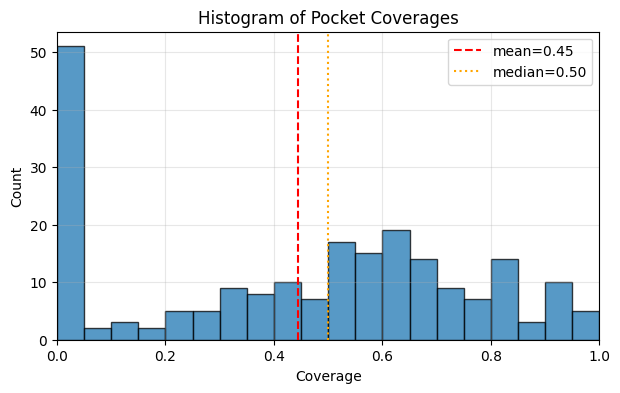

In [29]:
coverages = []
for protein_id in binding_residues.keys():
    y_true_pockets = binding_residues[protein_id]
    y_pred_pockets = model_predictions[protein_id]
    for y_true_pocket in y_true_pockets:
        max_coverage = 0
        for y_pred_pocket in y_pred_pockets:
            coverage = compute_coverage(y_true=y_true_pocket, y_pred=y_pred_pocket)
            if coverage > max_coverage:
                max_coverage = coverage
        coverages.append(max_coverage)


import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7, 4))
ax.hist(coverages, bins=20, range=(0, 1), color='C0', edgecolor='k', alpha=0.75)
mean_cov = np.mean(coverages)
median_cov = np.median(coverages)
ax.axvline(mean_cov, color='red', linestyle='--', linewidth=1.5, label=f"mean={mean_cov:.2f}")
ax.axvline(median_cov, color='orange', linestyle=':', linewidth=1.5, label=f"median={median_cov:.2f}")
ax.set_xlim(0, 1)
ax.set_xlabel("Coverage")
ax.set_ylabel("Count")
ax.set_title("Histogram of Pocket Coverages")
ax.legend()
ax.grid(alpha=0.3)
plt.show()

### Sanity check
This is the wrong way of computing residue coverage (I am aggregating the pockets together). But I wanted to check that it matches with the results from `src/E-regular-binding-site-predictor/evaluation/pocket-level-evaluation.ipynb`.

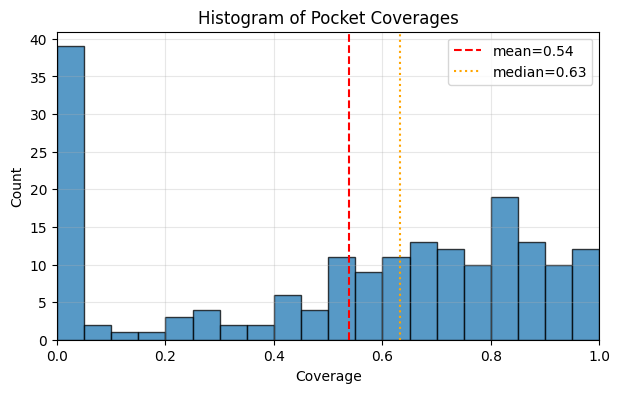

In [40]:
import numpy as np

def compute_coverage(y_true, y_pred):
    y_true_set = set(y_true)
    y_pred_set = set(y_pred)
    intersection = y_true_set.intersection(y_pred_set)
    coverage = len(intersection) / len(y_true_set)
    return coverage

coverages = []
for protein_id in binding_residues.keys():
    y_true_pockets = binding_residues[protein_id]
    y_pred_pockets = model_predictions[protein_id]
    if len(y_pred_pockets) == 0:
        coverages.append(0)
        continue
    y_true_pockets = np.concatenate(y_true_pockets)
    y_pred_pockets = np.concatenate(y_pred_pockets)
    coverage = compute_coverage(y_true=y_true_pockets, y_pred=y_pred_pockets)
    coverages.append(coverage) 

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7, 4))
ax.hist(coverages, bins=20, range=(0, 1), color='C0', edgecolor='k', alpha=0.75)
mean_cov = np.mean(coverages)
median_cov = np.median(coverages)
ax.axvline(mean_cov, color='red', linestyle='--', linewidth=1.5, label=f"mean={mean_cov:.2f}")
ax.axvline(median_cov, color='orange', linestyle=':', linewidth=1.5, label=f"median={median_cov:.2f}")
ax.set_xlim(0, 1)
ax.set_xlabel("Coverage")
ax.set_ylabel("Count")
ax.set_title("Histogram of Pocket Coverages")
ax.legend()
ax.grid(alpha=0.3)
plt.show()

### Number of predicted pockets inside actual pocket 
Compute how many predicted pockets are covering the actual pocket. Optimally, it should be just 1. 

#### TODO
How to check, to what extend is the predicted pocket covering the majority of the actual pocket? I.e., I don't mind if majority of the pocket is covered by one predicted pocket, and some marginal part of the actual pocket is covered by other pocket. What would be a problem, when the pocket is split between two predicted pockets. Or even worse, the pocket is almost not covered, only some marginal parts are covered by multiple predicted pockets (as seen in example from David).   

In [13]:
def get_counts(binding_residues, model_predictions):
    counts = []
    for protein_id in binding_residues.keys():
        y_true_pockets = binding_residues[protein_id]
        y_pred_pockets = model_predictions[protein_id]
        for y_true_pocket in y_true_pockets:
            number_of_predicted_pockets = 0
            for y_pred_pocket in y_pred_pockets:
                coverage = compute_coverage(y_true=y_true_pocket, y_pred=y_pred_pocket)
                if coverage > 0:
                    number_of_predicted_pockets += 1
            if number_of_predicted_pockets != 0:
                counts.append(number_of_predicted_pockets) 
    return counts

### GMM clustering + smoothing + additional agglomerative clustering (with PCAed embeddings and estimation of active clusters using GMM)

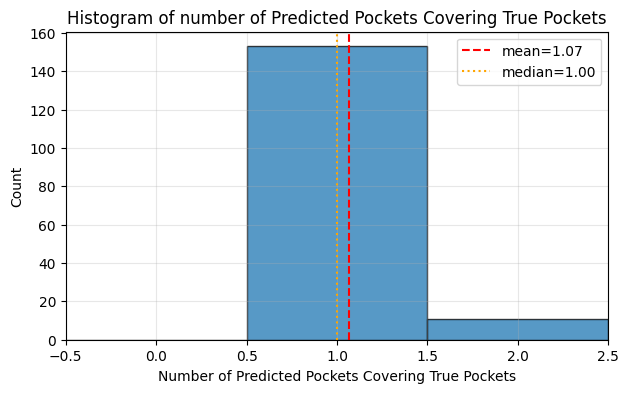

In [43]:
counts = get_counts(binding_residues, model_predictions)
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7, 4))
# replot with bins shifted by +0.5
bins = np.arange(-0.5, max(counts) + 1.5, 1)
ax.clear()
ax.hist(counts, bins=bins, color='C0', edgecolor='k', alpha=0.75)
mean_cov = np.mean(counts)
median_cov = np.median(counts)
ax.axvline(mean_cov, color='red', linestyle='--', label=f"mean={mean_cov:.2f}")
ax.axvline(median_cov, color='orange', linestyle=':', label=f"median={median_cov:.2f}")
ax.set_title("Histogram of number of Predicted Pockets Covering True Pockets")
ax.set_xlim(-0.5, max(counts) + 0.5)
ax.set_xlabel("Number of Predicted Pockets Covering True Pockets")
ax.set_ylabel("Count")
ax.legend()
ax.grid(alpha=0.3)
plt.show()

# this is clustering agglomerative clustering (with PCAed embeddings and estimation of active clusters using GMM) + smoothing 


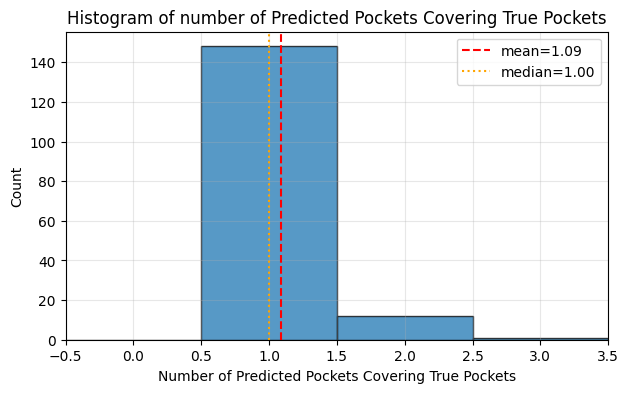

In [45]:
counts = get_counts(binding_residues, model_predictions)
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7, 4))
# replot with bins shifted by +0.5
bins = np.arange(-0.5, max(counts) + 1.5, 1)
ax.clear()
ax.hist(counts, bins=bins, color='C0', edgecolor='k', alpha=0.75)
mean_cov = np.mean(counts)
median_cov = np.median(counts)
ax.axvline(mean_cov, color='red', linestyle='--', label=f"mean={mean_cov:.2f}")
ax.axvline(median_cov, color='orange', linestyle=':', label=f"median={median_cov:.2f}")
ax.set_title("Histogram of number of Predicted Pockets Covering True Pockets")
ax.set_xlim(-0.5, max(counts) + 0.5)
ax.set_xlabel("Number of Predicted Pockets Covering True Pockets")
ax.set_ylabel("Count")
ax.legend()
ax.grid(alpha=0.3)
plt.show()

### GMM-tied

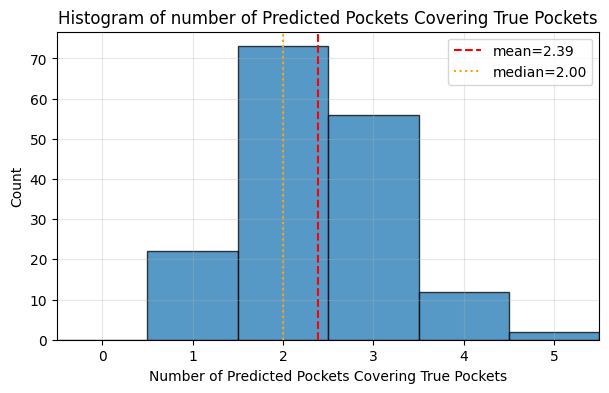

In [35]:
counts = get_counts(binding_residues, model_predictions)
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7, 4))
# replot with bins shifted by +0.5
bins = np.arange(-0.5, max(counts) + 1.5, 1)
ax.clear()
ax.hist(counts, bins=bins, color='C0', edgecolor='k', alpha=0.75)
mean_cov = np.mean(counts)
median_cov = np.median(counts)
ax.axvline(mean_cov, color='red', linestyle='--', label=f"mean={mean_cov:.2f}")
ax.axvline(median_cov, color='orange', linestyle=':', label=f"median={median_cov:.2f}")
ax.set_title("Histogram of number of Predicted Pockets Covering True Pockets")
ax.set_xlim(-0.5, max(counts) + 0.5)
ax.set_xlabel("Number of Predicted Pockets Covering True Pockets")
ax.set_ylabel("Count")
ax.legend()
ax.grid(alpha=0.3)
plt.show()

### this is GMM full

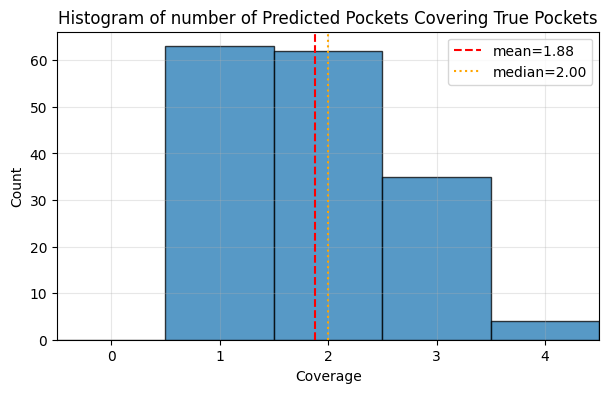

In [14]:
counts = get_counts(binding_residues, model_predictions)
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7, 4))
# replot with bins shifted by +0.5
bins = np.arange(-0.5, max(counts) + 1.5, 1)
ax.clear()
ax.hist(counts, bins=bins, color='C0', edgecolor='k', alpha=0.75)
mean_cov = np.mean(counts)
median_cov = np.median(counts)
ax.axvline(mean_cov, color='red', linestyle='--', label=f"mean={mean_cov:.2f}")
ax.axvline(median_cov, color='orange', linestyle=':', label=f"median={median_cov:.2f}")
ax.set_title("Histogram of number of Predicted Pockets Covering True Pockets")
ax.set_xlim(-0.5, max(counts) + 0.5)
ax.set_xlabel("Coverage")
ax.set_ylabel("Count")
ax.legend()
ax.grid(alpha=0.3)
plt.show()

# this is dbscan

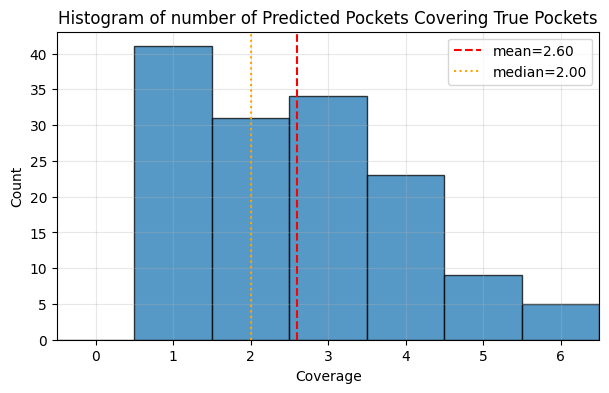

In [22]:
import matplotlib.pyplot as plt

counts = get_counts(binding_residues, model_predictions)

fig, ax = plt.subplots(figsize=(7, 4))
# replot with bins shifted by +0.5
bins = np.arange(-0.5, max(counts) + 1.5, 1)
ax.clear()
ax.hist(counts, bins=bins, color='C0', edgecolor='k', alpha=0.75)
mean_cov = np.mean(counts)
median_cov = np.median(counts)
ax.axvline(mean_cov, color='red', linestyle='--', label=f"mean={mean_cov:.2f}")
ax.axvline(median_cov, color='orange', linestyle=':', label=f"median={median_cov:.2f}")
ax.set_title("Histogram of number of Predicted Pockets Covering True Pockets")
ax.set_xlim(-0.5, max(counts) + 0.5)
ax.set_xlabel("Coverage")
ax.set_ylabel("Count")
ax.legend()
ax.grid(alpha=0.3)
plt.show()

# this is GMM

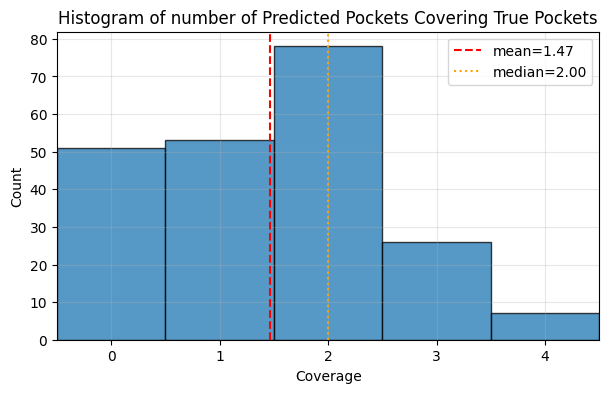

In [33]:
counts = []
for protein_id in binding_residues.keys():
    y_true_pockets = binding_residues[protein_id]
    y_pred_pockets = model_predictions[protein_id]
    for y_true_pocket in y_true_pockets:
        number_of_predicted_pockets = 0
        for y_pred_pocket in y_pred_pockets:
            coverage = compute_coverage(y_true=y_true_pocket, y_pred=y_pred_pocket)
            if coverage > 0:
                number_of_predicted_pockets += 1
        counts.append(number_of_predicted_pockets) 

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7, 4))
# replot with bins shifted by +0.5
bins = np.arange(-0.5, max(counts) + 1.5, 1)
ax.clear()
ax.hist(counts, bins=bins, color='C0', edgecolor='k', alpha=0.75)
mean_cov = np.mean(counts)
median_cov = np.median(counts)
ax.axvline(mean_cov, color='red', linestyle='--', label=f"mean={mean_cov:.2f}")
ax.axvline(median_cov, color='orange', linestyle=':', label=f"median={median_cov:.2f}")
ax.set_title("Histogram of number of Predicted Pockets Covering True Pockets")
ax.set_xlim(-0.5, max(counts) + 0.5)
ax.set_xlabel("Coverage")
ax.set_ylabel("Count")
ax.legend()
ax.grid(alpha=0.3)
plt.show()

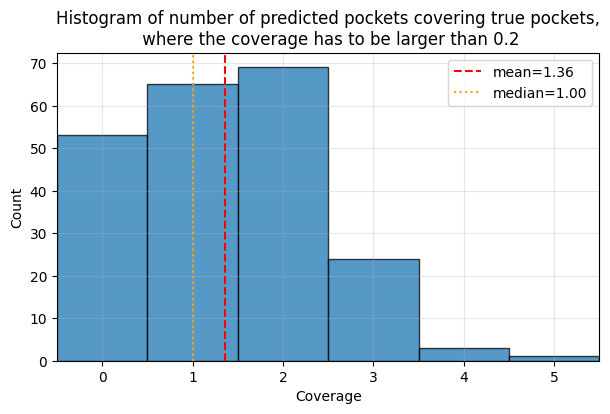

In [26]:
counts = []
for protein_id in binding_residues.keys():
    y_true_pockets = binding_residues[protein_id]
    y_pred_pockets = model_predictions[protein_id]
    for y_true_pocket in y_true_pockets:
        number_of_predicted_pockets = 0
        for y_pred_pocket in y_pred_pockets:
            coverage = compute_coverage(y_true=y_true_pocket, y_pred=y_pred_pocket)
            if coverage > 0.1:
                number_of_predicted_pockets += 1
        counts.append(number_of_predicted_pockets) 

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7, 4))
# replot with bins shifted by +0.5
bins = np.arange(-0.5, max(counts) + 1.5, 1)
ax.clear()
ax.hist(counts, bins=bins, color='C0', edgecolor='k', alpha=0.75)
mean_cov = np.mean(counts)
median_cov = np.median(counts)
ax.axvline(mean_cov, color='red', linestyle='--', label=f"mean={mean_cov:.2f}")
ax.axvline(median_cov, color='orange', linestyle=':', label=f"median={median_cov:.2f}")
ax.set_title("Histogram of number of predicted pockets covering true pockets,\n where the coverage has to be larger than 0.2")
ax.set_xlim(-0.5, max(counts) + 0.5)
ax.set_xlabel("Coverage")
ax.set_ylabel("Count")
ax.legend()
ax.grid(alpha=0.3)
plt.show()

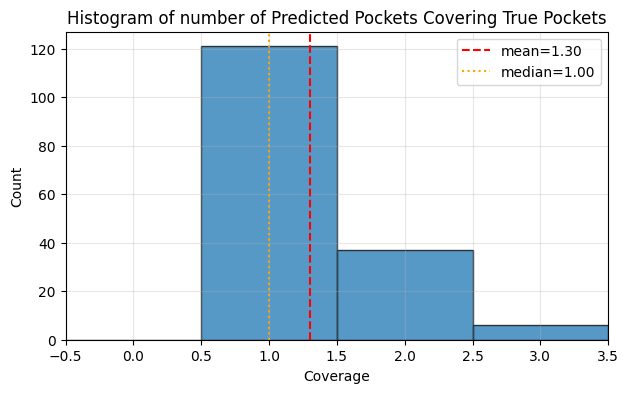

In [41]:
import matplotlib.pyplot as plt

counts = get_counts(binding_residues, model_predictions)

fig, ax = plt.subplots(figsize=(7, 4))
# replot with bins shifted by +0.5
bins = np.arange(-0.5, max(counts) + 1.5, 1)
ax.clear()
ax.hist(counts, bins=bins, color='C0', edgecolor='k', alpha=0.75)
mean_cov = np.mean(counts)
median_cov = np.median(counts)
ax.axvline(mean_cov, color='red', linestyle='--', label=f"mean={mean_cov:.2f}")
ax.axvline(median_cov, color='orange', linestyle=':', label=f"median={median_cov:.2f}")
ax.set_title("Histogram of number of Predicted Pockets Covering True Pockets")
ax.set_xlim(-0.5, max(counts) + 0.5)
ax.set_xlabel("Coverage")
ax.set_ylabel("Count")
ax.legend()
ax.grid(alpha=0.3)
plt.show()

# TODO: Compute intersection over union with & without smoothing